# EPIC220208795 -- Figure Making

In this notebook we make the figures for the paper 

In [1]:
import emcee
import logging
import numpy as np
import astropy.units as u
import astropy.constants as c
import matplotlib.pyplot as plt
from Code import mcmc, eclipse

%matplotlib inline

In [2]:
SMALL_SIZE = 8*2                                        
MEDIUM_SIZE = 12*2
BIGGER_SIZE = 16*2

plt.rc('font', size=MEDIUM_SIZE, family='serif')          # controls default text sizes
plt.rc('axes', titlesize=MEDIUM_SIZE)                     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)                     # fontsize of the x and y labels
plt.rc('xtick', labelsize=MEDIUM_SIZE, direction='in')    # fontsize of the tick labels
plt.rc('ytick', labelsize=MEDIUM_SIZE, direction='in')    # fontsize of the tick labels
plt.rc('legend', fontsize=MEDIUM_SIZE)                    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)                  # fontsize of the figure title
plt.rc('figure', figsize='8, 6')                         # size of the figure, used to be '4, 3' in inches

In [3]:
time, flux, error = np.loadtxt('data 2202/eclipse_lightcurve2202.txt', skiprows=1).T

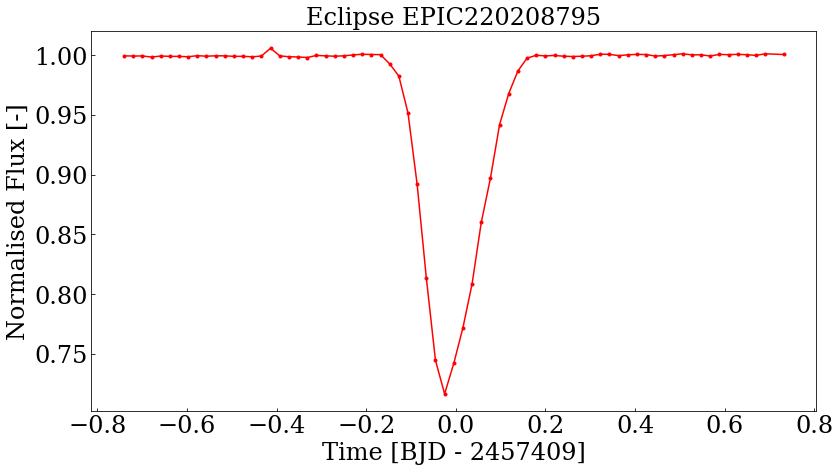

In [4]:
plt.figure(figsize=(13, 7))
plt.title('Eclipse EPIC220208795')
plt.xlabel('Time [BJD - 2457409]')
plt.ylabel('Normalised Flux [-]')
plt.errorbar(time, flux, yerr=error, fmt='.', color='r', ls='-')
plt.savefig('EPIC2202Data.pdf')
plt.show()

In [5]:
time_full, flux_full, error_full = np.loadtxt('data 2202/everest_lightcurve2202.txt', skiprows=1).T

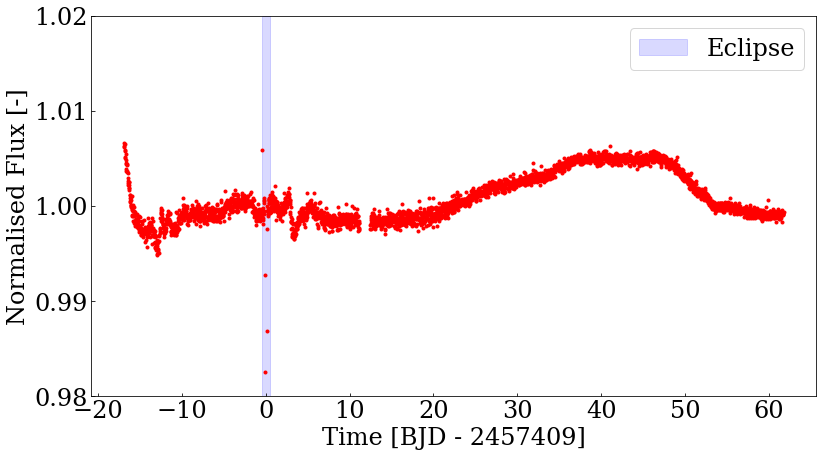

In [6]:
plt.figure(figsize=(13, 7))
#plt.title('EVEREST EPIC220208795')
plt.xlabel('Time [BJD - 2457409]')
plt.ylabel('Normalised Flux [-]')
plt.ylim(0.98,1.02)

plt.errorbar(time_full-2576, flux_full, yerr=error_full, fmt='.', color='r')
plt.errorbar(time, flux, yerr=error, fmt='.', color='r')
plt.axvspan(-0.5, 0.5, color='blue', alpha=0.15, label='Eclipse')
plt.legend()
plt.savefig('EPIC2202Data_FULL.pdf')
plt.show()

C:\Users\lvand\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: MatplotlibDeprecationWarning: 
The mpl_toolkits.axes_grid module was deprecated in Matplotlib 2.1 and will be removed two minor releases later. Use mpl_toolkits.axes_grid1 and mpl_toolkits.axisartist, which provide the same functionality instead.
  """Entry point for launching an IPython kernel.


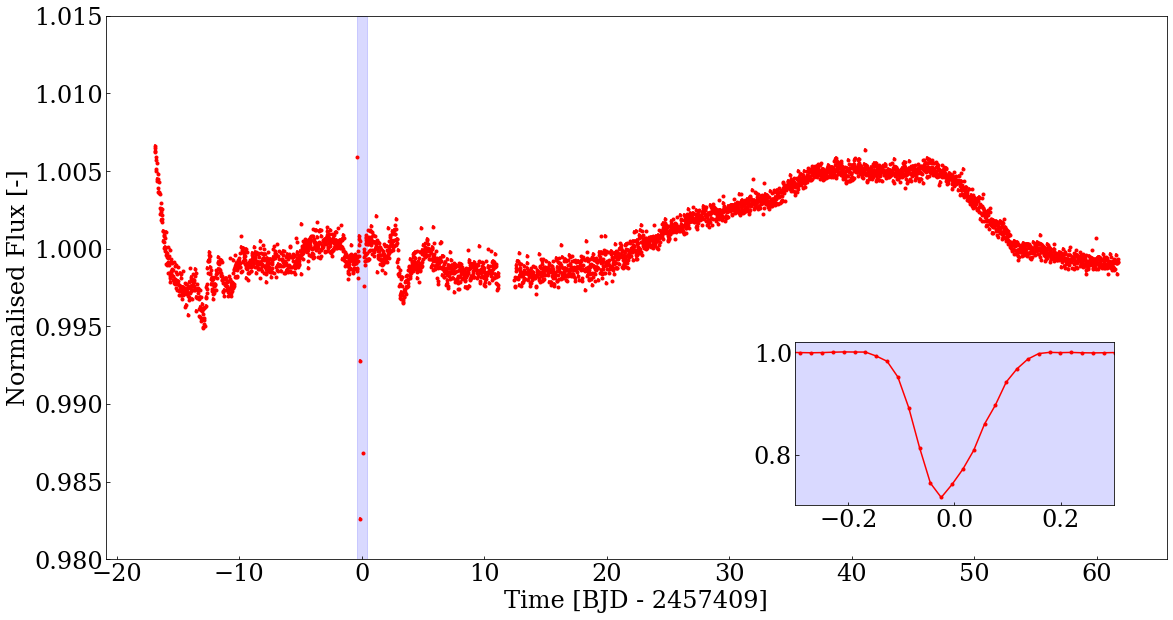

In [7]:
from mpl_toolkits.axes_grid.inset_locator import (inset_axes, InsetPosition,mark_inset)


#fig = plt.figure(figsize=(18, 8))
#gs = fig.add_gridspec(1, 2, hspace=0, wspace=0, width_ratios=[10, 5])
#ax1, ax2 = gs.subplots(sharey='row')

fig, ax1 = plt.subplots(figsize=(19,10))
ax1.errorbar(time_full-2576, flux_full, yerr=error_full, fmt='.', color='r')
ax1.errorbar(time, flux, yerr=error, fmt='.', color='r')
ax1.axvspan(-0.4, 0.4, color='blue', alpha=0.15, label='Eclipse')
#ax1.axvspan(11, 12.5, color='green', alpha=0.15, label='Noise')

ax2 = plt.axes([0,0,1,1])
# Manually set the position and relative size of the inset axes within ax1
ip = InsetPosition(ax1, [0.65,0.1,0.3,0.3])
ax2.set_axes_locator(ip)

ax2.errorbar(time, flux, yerr=error, fmt='.', color='r', ls='-')
ax2.axvspan(-0.5, 0.5, color='blue', alpha=0.15, label='Eclipse')

#ax3 = plt.axes([0,0,2,2])
# Manually set the position and relative size of the inset axes within ax1
#ip = InsetPosition(ax1, [0.75,0.1,0.22,0.22])
#ax3.set_axes_locator(ip)

#ax3.errorbar(time_full-2576, flux_full, yerr=error_full, fmt='.', color='r', ls='-')
#ax3.axvspan(11, 12.5, color='green', alpha=0.15, label='Noise')

ax1.set_xlabel('Time [BJD - 2457409]')
ax1.set_ylabel('Normalised Flux [-]')
#ax1.legend()

ax2.set_xlim(-0.3,0.3)

#ax3.set_xlim(11.1,12.5)
#ax3.set_ylim(0.98,1.007)

ax1.set_ylim(0.98,1.015)

plt.savefig('EPIC2202Data_FULL_DOUBLE.pdf')
plt.show()


# Model Set-up

In [5]:
# model functions
fuzzy_disk       = eclipse.disk_model
fuzzy_prior       = eclipse.disk_prior

In [6]:
# Bounds of the parameters (t = tilt, T = tau, rest as above)
rl, ru = (0., 10.)
bl, bu = (-10.,10.)
il, iu = (0., np.pi/2.)
tl, tu = (0., np.pi/2.)
vl, vu = (4.3, 15) # 220208795
xl, xu = (-10.,10.)
Tl, Tu = (0.,1.)

## Hard-edged disk model

In [15]:
# model functions
pack_osd = lambda rd, b, inc, tilt, vel, dx: (rd, 0., b, inc, tilt, vel, dx, 1., 0.)
opaque_small_disk      = lambda P, time: eclipse.disk_model(pack_osd(*P), time)
opaque_small_prior      = lambda P: eclipse.disk_prior(pack_osd(*P))

# setting up labels, units and bounds for the opaque_small disk
lbls_osd = ['$R_d$', '$b$', '$i$', '$\phi$', '$v_t$',
           '$\delta$t']
units_osd = ['R*', 'R*', 'deg', 'deg', 'R*/day', 'day']
bounds_osd = [(rl, ru/2.), (bl/2., bu/2.), (iu/2., iu), (tl, tu),  (vl,vu/2.),
             (-0.5, 0.5),]

In [16]:
be_osd = 'models 2202/opaque_small_disk_2202.h5'
mcmc_args_osd = (time, flux, error, opaque_small_disk, opaque_small_prior)
BE_osd = emcee.backends.HDFBackend(be_osd)


# load mcmc for the opaque_small disk
sampler_osd = emcee.EnsembleSampler(1000, 6, mcmc.lnprob, args=mcmc_args_osd, backend=BE_osd)

100%|████████████████████████████████████████████████████████████████████████████████| 300/300 [00:45<00:00,  6.57it/s]


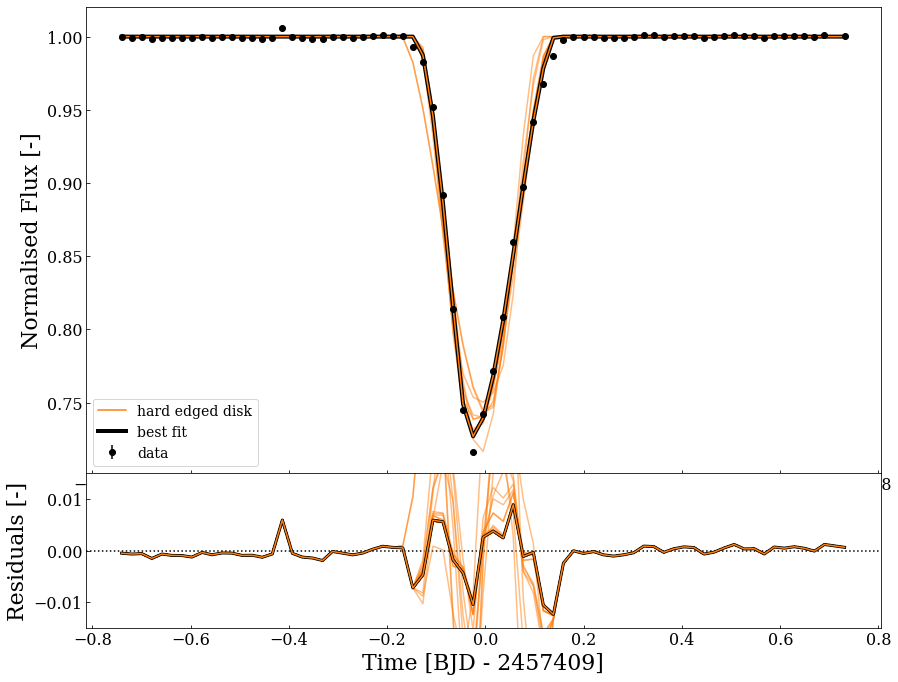

In [17]:
# determine burn-in for the opaque 'small' disk
cut_osd = 500

# carry out statistics for the solutions for the opaque 'small' disk
stats_osd, pb_osd = mcmc.stats(sampler_osd, cut=cut_osd)

# plot the samples for the solutions for the opaque 'small' disk
_ = mcmc.plot_samples(time, flux, error, [opaque_small_disk], [sampler_osd], ['hard edged disk'], cut_osd, 300, 
                 best_fit=True, dt=0, alpha=0.5, residual_lims=(-0.015,0.015), savename='hard_edged_runBIGFONT.pdf')

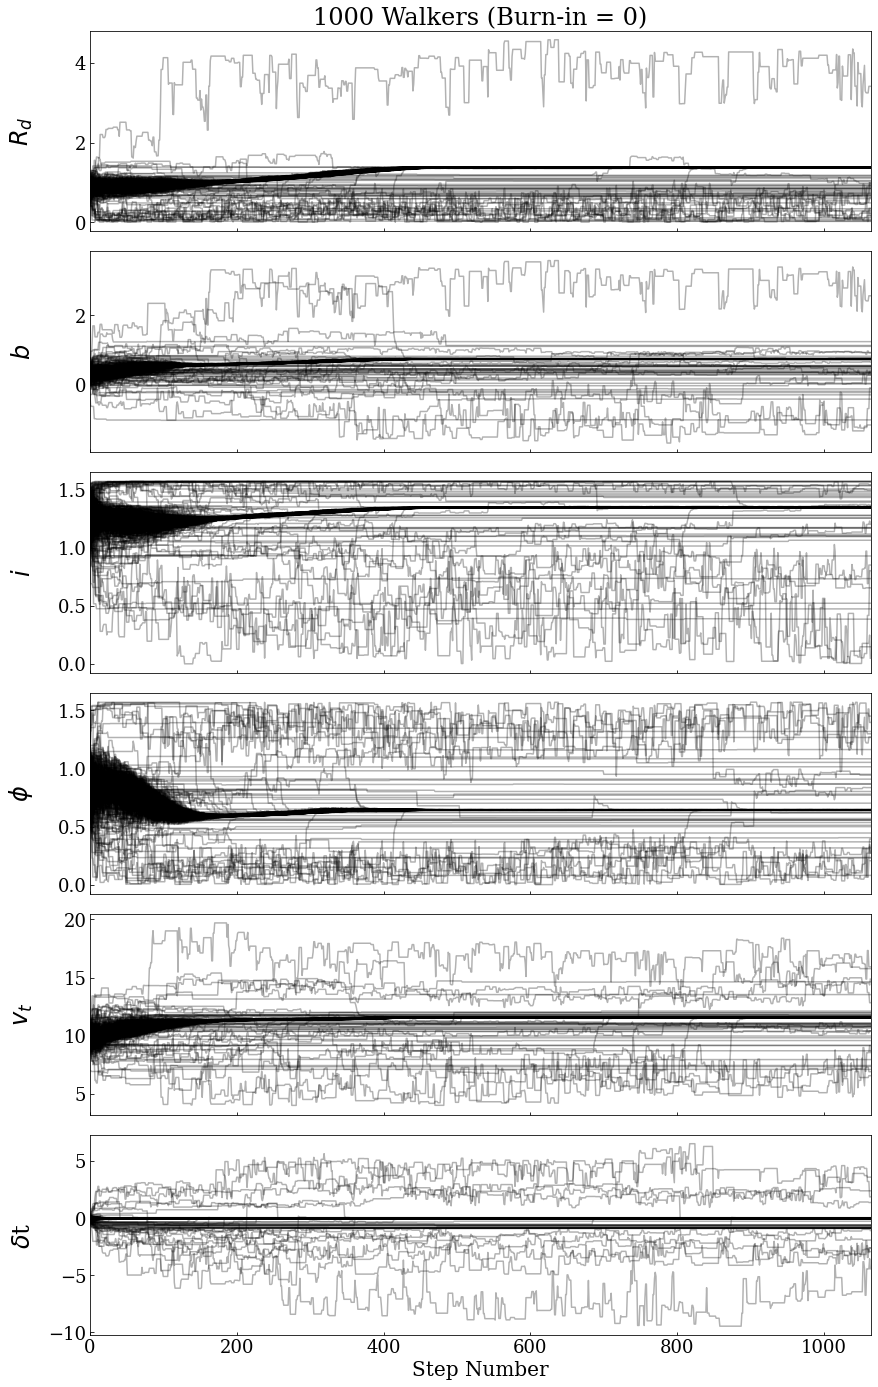

In [16]:
mcmc.plot_walkers(sampler_osd, 0, lbls_osd)

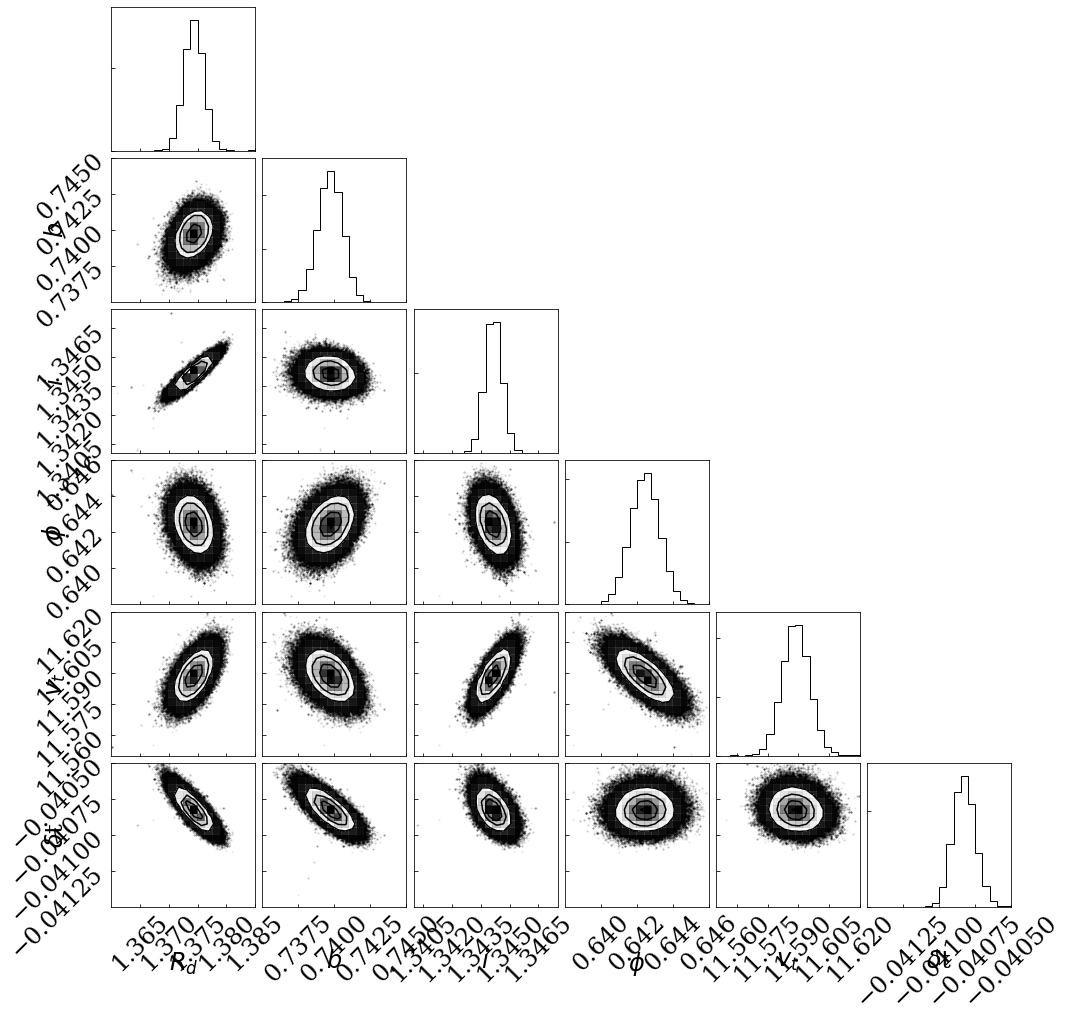

In [17]:
#triangle plot
mcmc.plot_triangle(sampler_osd, 500, lbls_osd, savename='hard_edged_triangleBIGFONT.pdf', bounds=((1.36,1.385),(0.735,0.745),(1.34,1.3475),(0.638,0.646),(11.55,11.62),(-0.0415,-0.0405)))

## Soft edged disk

In [18]:
# model functions
pack_osf = lambda rd, re, b, inc, tilt, vel, dx, te: (rd, re, b, inc, tilt, vel, dx, 1., te)
fuzzy_small_disk      = lambda P, time: eclipse.disk_model(pack_osf(*P), time)
fuzzy_small_prior      = lambda P: eclipse.disk_prior(pack_osf(*P))

# setting up labels, units and bounds for the fuzzy_small disk
lbls_osf = ['$R_d$', '$t_e$', '$b$', '$i$', '$\phi$', '$v_t$',
           '$\delta$t', r'$\tau_e$']
units_osf = ['R*', 'R*', 'R*', 'deg', 'deg', 'R*/day', 'day', '-']
bounds_osf = [(rl, ru/2.), (rl, ru/2.), (bl/2., bu/2.), (iu/2., iu), (tl, tu), (vl, vu/2.), 
             (-0.5, 0.5), (Tl, Tu/2.)]

In [19]:
# mcmc parameters for the best fit disk with fuzzy edge
be_osf = 'models 2202/fuzzy_small_disk_2202.h5'
mcmc_args_osf = (time, flux, error, fuzzy_small_disk, fuzzy_small_prior)
BE_osf = emcee.backends.HDFBackend(be_osf)


# load mcmc for the fuzzy_small disk
sampler_osf = emcee.EnsembleSampler(1000, 8, mcmc.lnprob, args=mcmc_args_osf, backend=BE_osf)

100%|████████████████████████████████████████████████████████████████████████████████| 300/300 [01:37<00:00,  3.07it/s]


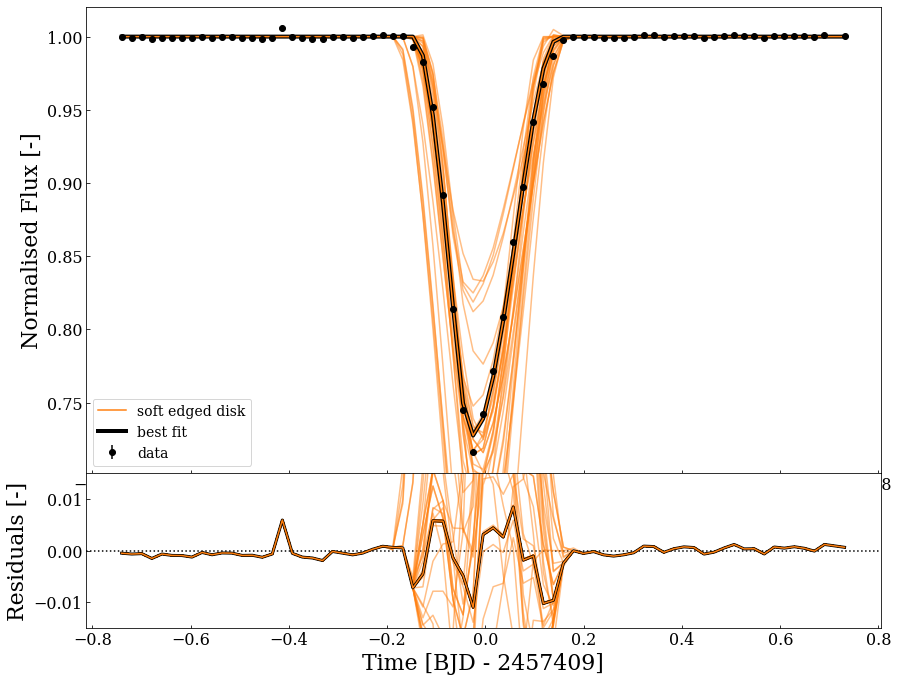

In [20]:
# determine burn-in for the fuzzy disk
cut_osf = 550

# carry out statistics for solutions for the fuzzy disk
stats_osf, pb_osf = mcmc.stats(sampler_osf, cut=cut_osf)

# plot the samples for the fuzzy disk
_ = mcmc.plot_samples(time, flux, error, [fuzzy_small_disk], [sampler_osf], ['soft edged disk'], cut_osf, 300, 
                 best_fit=True, dt=0, alpha=0.5, residual_lims=(-0.015,0.015), savename='soft_edged_runBIGFONT.pdf')

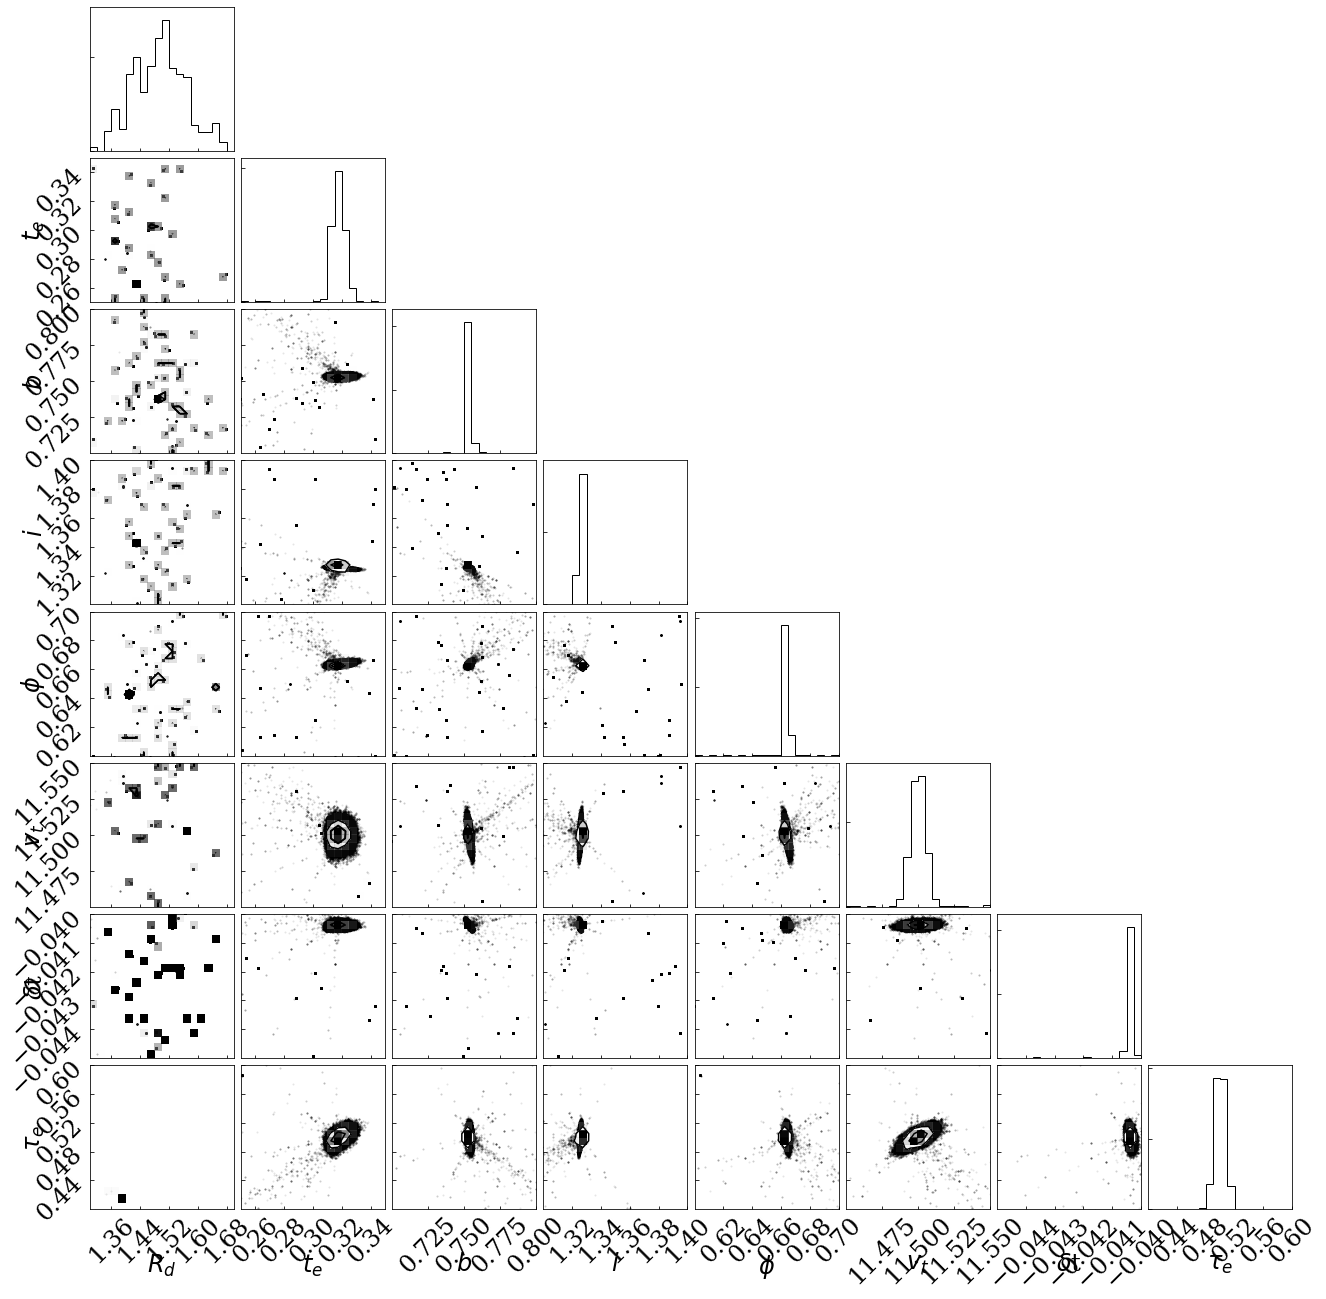

In [32]:
mcmc.plot_triangle(sampler_osf, 550, lbls_osf, savename='soft_edged_triangle.pdf', bounds=((1.3,1.7),(0.25,0.35),(0.7,0.8),(1.3,1.4),(0.6,0.7),(11.45,11.55),(-0.045,-0.04),(0.4,0.6)))

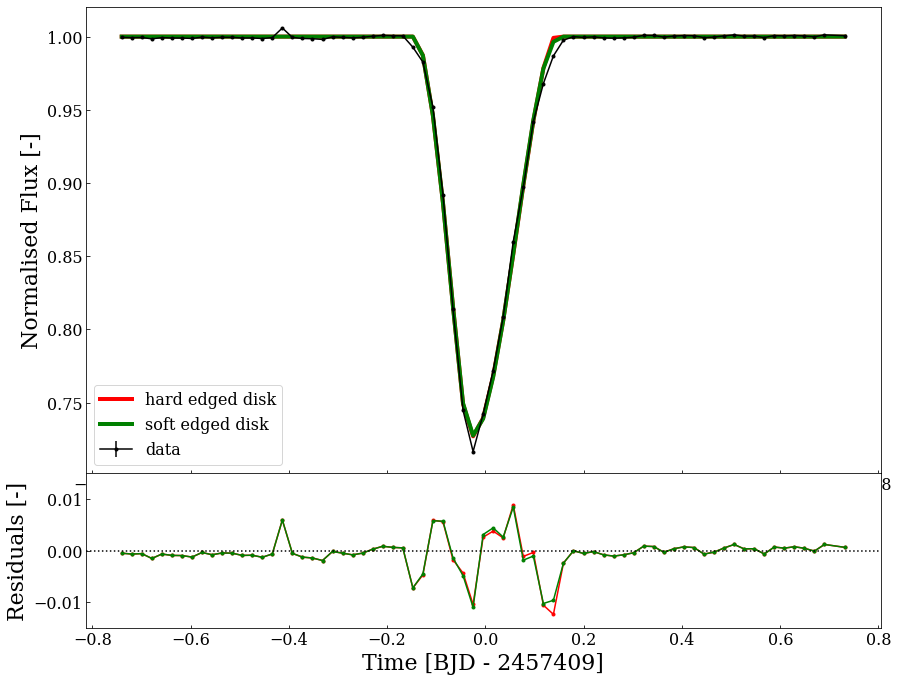

In [28]:
#comparison
model_list = [opaque_small_disk, fuzzy_small_disk]
P_list = [pb_osd, pb_osf]

chi2 = mcmc.plot_models(time, flux, error, model_list, P_list, ['hard edged disk','soft edged disk'], dt=0, residual_lims=(-0.015,0.015), savename='comparison_plots.pdf')

In [29]:
print(chi2/len(time))

[982.35008155 916.03628091]


## Visual plot

the star has a linear limb-darkening parameter of 0.7220
the disk system is inclined by 77.01 [deg] and tilted by 36.81 [deg]     with an impact parameter of 0.74 [R*]
the disk system travels at 11.59 [R* / day] and is offset by -0.04     days
    ring 1 with r_in = 0.0000, r_out = 1.3742 and tau = 1.0000


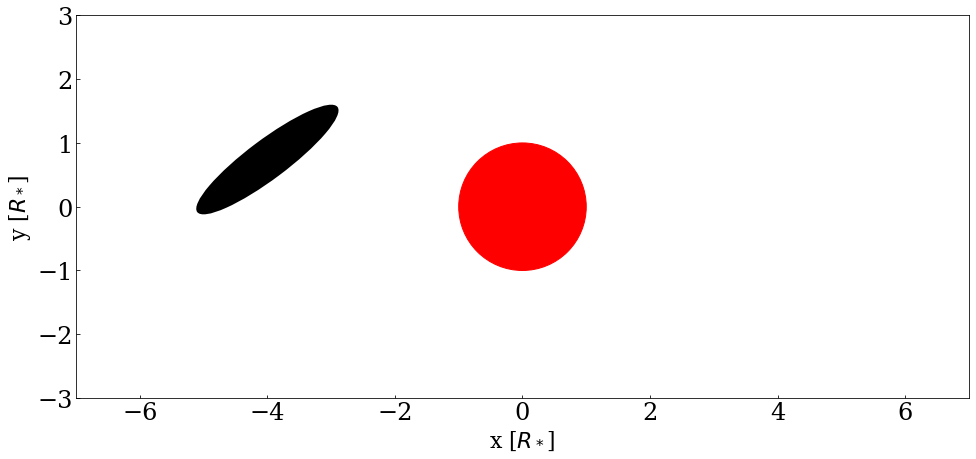

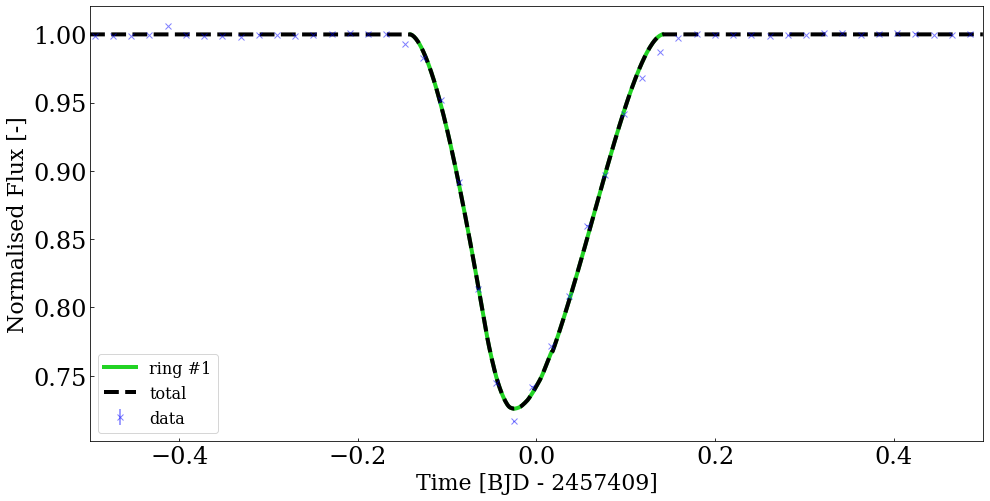

In [15]:
model_time = np.linspace(-0.5, 0.5, 1001)

r1, b1, i1, t1, v1, x1  = pb_osd
lcm1 = eclipse.light_curve_model(model_time, [r1], b1, i1, t1, v1, x1, [1], 0.7220, 1, 0)
eclipse.make_plots(*lcm1, model_time, time, flux, error, "EPIC220208795", dt=0, xlim1=(-7,7), ylim1=(-3,3), savename1='modeldepic.pdf',savename2='modelcurve.pdf')

the star has a linear limb-darkening parameter of 0.7220
the disk system is inclined by 75.94 [deg] and tilted by 38.04 [deg]     with an impact parameter of 0.75 [R*]
the disk system travels at 11.50 [R* / day] and is offset by -0.04     days
    ring 1 with r_in = 0.0000, r_out = 1.1631 and tau = 1.0000
    ring 2 with r_in = 1.1631, r_out = 1.4801 and tau = 0.4987


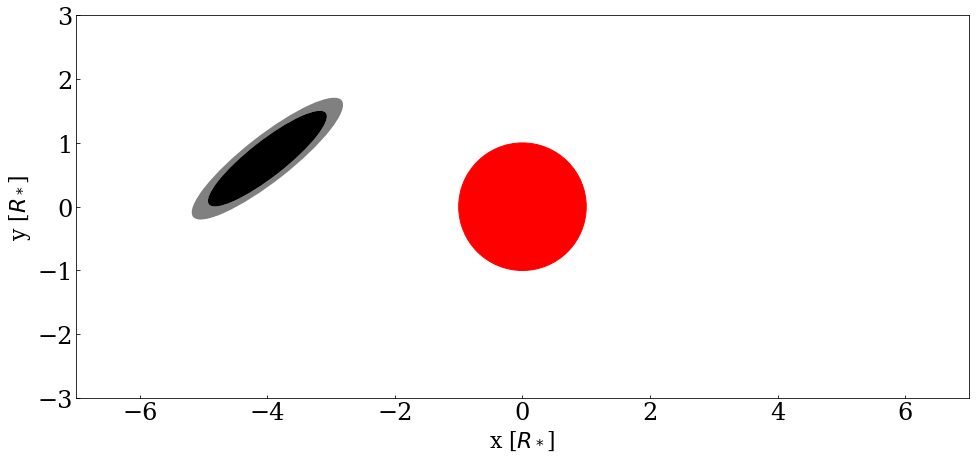

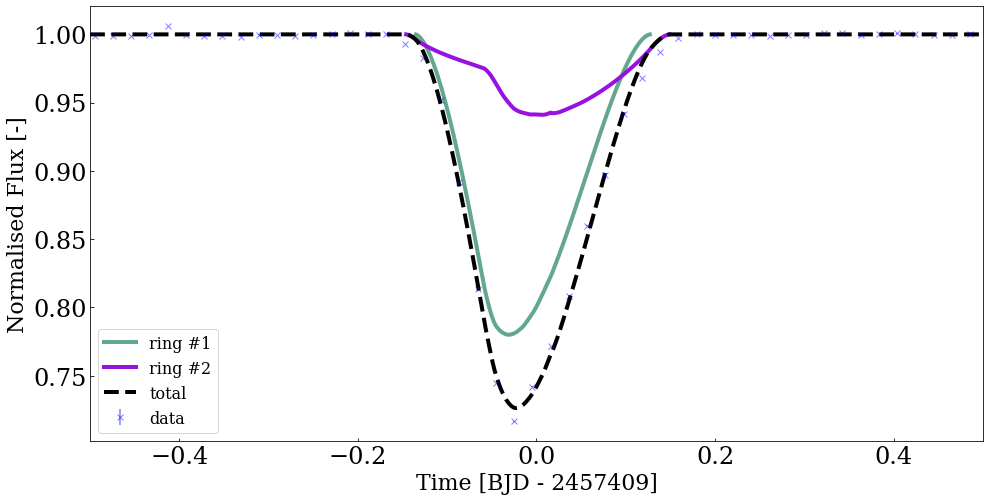

In [16]:
r2, er2, b2, i2, t2, v2, x2, eo2  = pb_osf
lcm2 = eclipse.light_curve_model(model_time, [r2,er2], b2, i2, t2, v2, x2, [1,eo2], 0.7220, 1, 0)
eclipse.make_plots(*lcm2, model_time, time, flux, error, "EPIC220208795", dt=0, xlim1=(-7,7), ylim1=(-3,3), savename1='modeldepic_soft.pdf',savename2='modelcurve_soft.pdf')

## COMPARISON PLOTS

Here we make the plot comparing Rappaport et al. (2019)'s model and van Dam et al. (2020)'s model to our model

In [19]:
#Parameters 
R_Liz = 0.83 #Rsun
R_Rap = 0.63
R_Tau = 1.38

Rd_Liz = 1.374 #Rstar
Rd_Rap = 4.2
Rd_Tau = 0.9923

b_Liz = -0.739 #Rstar
b_Rap = -0.88
b_Tau = -0.2506

Inc_Liz = -77.01 #deg
Inc_Rap = 77.77
Inc_Tau = 56.78

Tilt_Liz = -36.81 #deg
Tilt_Rap = 18.1
Tilt_Tau = 41.22

In [20]:
#making ring patches
#ring_patch(rin, rout, inc_deg, tilt_deg, tau, dr=([0, 0]))
from matplotlib.patches import Ellipse, Circle, PathPatch

Disk_Liz = eclipse.ring_patch(0,Rd_Liz*R_Liz, Inc_Liz, Tilt_Liz, 1, [-2,b_Liz*R_Liz])

In [21]:
Disk_Rap = eclipse.ring_patch(0,Rd_Rap*R_Rap, Inc_Rap, Tilt_Rap, 1, [8+R_Rap+R_Liz,b_Rap*R_Rap])

In [22]:
Disk_Tau = eclipse.ring_patch(0,Rd_Tau*R_Tau, Inc_Tau, Tilt_Tau, 1, [21+2*R_Rap+R_Tau+R_Liz,b_Tau*R_Tau])

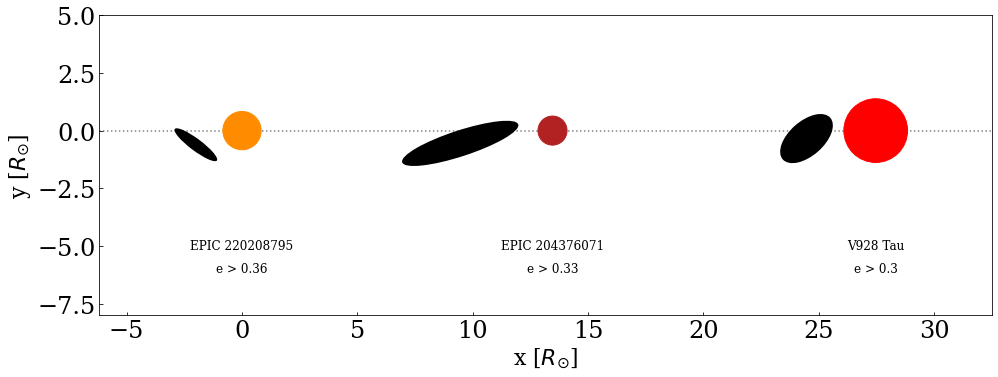

In [23]:
#Stars
star_Liz = Circle((0,0),R_Liz, color='darkorange')
star_Rap = Circle((12+R_Rap+R_Liz,0),R_Rap, color='firebrick')
star_Tau = Circle((24+2*R_Rap+R_Tau+R_Liz,0),R_Tau, color='r')
fig = plt.figure(figsize=(16,8))
plt.gca().set_aspect('equal')
plt.gca().add_patch(star_Liz)
plt.gca().add_patch(Disk_Liz)
plt.gca().add_patch(star_Rap)
plt.gca().add_patch(Disk_Rap)
plt.gca().add_patch(star_Tau)
plt.gca().add_patch(Disk_Tau)


plt.text(0,-5,'EPIC 220208795',horizontalalignment='center',verticalalignment='center', fontsize=12)
plt.text(12+R_Rap+R_Liz,-5,'EPIC 204376071',horizontalalignment='center',verticalalignment='center', fontsize=12)
plt.text(24+2*R_Rap+R_Tau+R_Liz,-5,'V928 Tau',horizontalalignment='center',verticalalignment='center', fontsize=12)
plt.text(0,-6,'e > 0.36',horizontalalignment='center',verticalalignment='center', fontsize=12)
plt.text(12+R_Rap+R_Liz,-6,'e > 0.33',horizontalalignment='center',verticalalignment='center', fontsize=12)
plt.text(24+2*R_Rap+R_Tau+R_Liz,-6,'e > 0.3',horizontalalignment='center',verticalalignment='center', fontsize=12)


plt.xlabel('x [$R_{\odot}$]', fontsize=22)
plt.ylabel('y [$R_{\odot}$]', fontsize=22)
plt.gca().axhline(y=0, color="grey", zorder=-10, ls=":")
plt.ylim(-8,5)
plt.xlim(-6.2,32.5)
plt.savefig('Modelcomparison.pdf')
plt.show()